Arvid Lundervold, 2025-01-15

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/BMED365-2025/blob/main/Lab2-DL/notebooks/01-MNIST-collect-organize.ipynb)

### NB 1: MNIST Collect and Organize Data


In [2]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")

Not running in Google Colab.


Loading MNIST data...

Total available MNIST samples: 70000
Using 5000 samples

MNIST Dataset Info:
Features (pixels): 784
Classes: 10

Class distribution:
0    490
1    551
2    483
3    556
4    433
5    476
6    490
7    515
8    489
9    517
Name: count, dtype: int64

Feature Statistics:
       pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
count   5000.0   5000.0   5000.0   5000.0   5000.0   5000.0   5000.0   5000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0

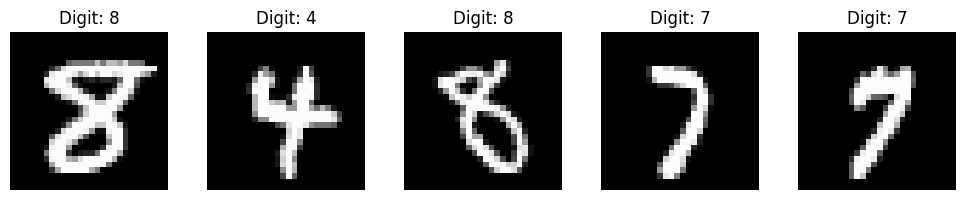


Feature Analysis:
Zero-variance features: 118
Features with >50% zeros: 15

Top 10 most correlated pixels with digit label:
pixel_381    0.427864
pixel_436    0.416663
pixel_408    0.411302
pixel_409    0.408674
pixel_464    0.367394
pixel_354    0.358443
pixel_353    0.355289
pixel_437    0.353728
pixel_382    0.338701
pixel_380    0.314135
Name: label, dtype: float64
Number of NaN values: 117


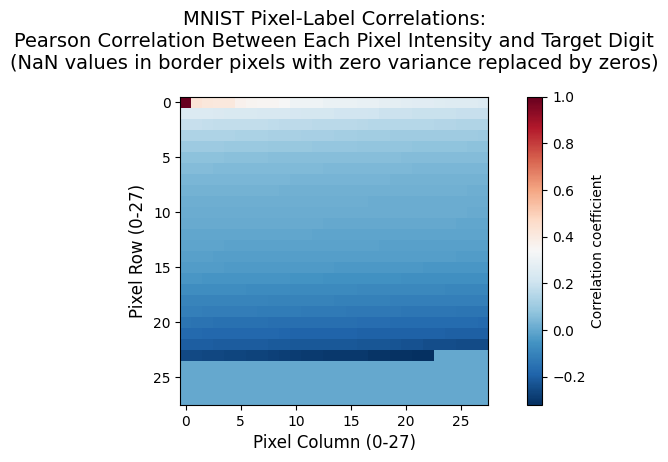

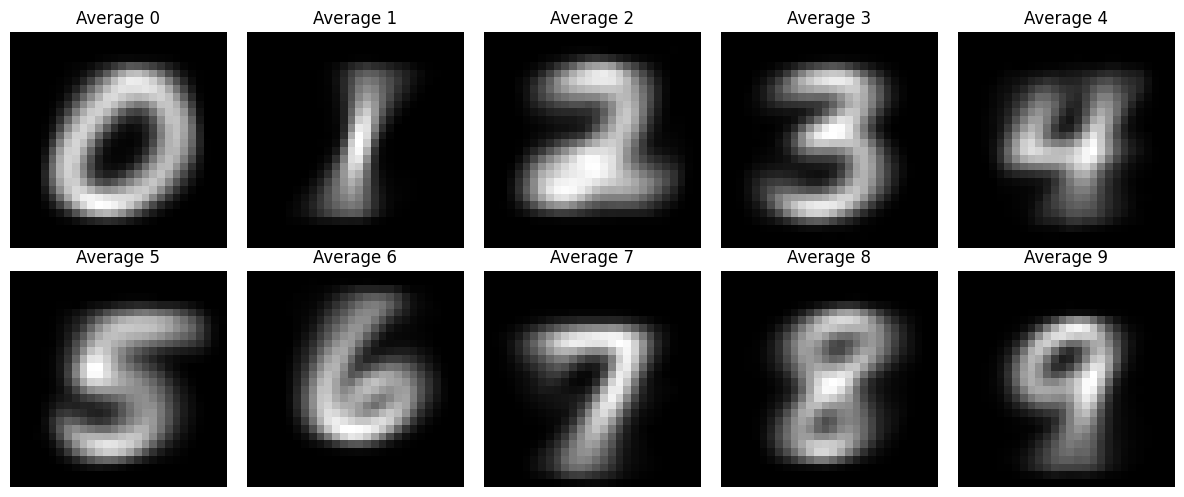

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import os

def load_mnist_tabular(n_samples=None, random_state=42):
    """
    Load MNIST dataset as tabular data using scikit-learn
    
    Parameters:
    -----------
    n_samples : int, optional
        Number of samples to load. If None, loads all 70,000 samples.
        If n_samples is larger than 70,000, uses all available data.
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    X : array-like of shape (n_samples, 784)
        Each row is a flattened 28x28 image
    y : array-like of shape (n_samples,)
        Target labels (digits 0-9)
    """
    print("Loading MNIST data...")
    mnist = fetch_openml('mnist_784', version=1, as_frame=True, parser='auto')
    X = mnist.data.values / 255.0  # Scale to [0,1]
    y = mnist.target.astype(int).values  # Convert to numpy array
    
    total_samples = len(X)
    print(f"\nTotal available MNIST samples: {total_samples}")
    
    if n_samples is not None:
        # Make sure we don't try to sample more than available
        n_samples = min(n_samples, total_samples)
        print(f"Using {n_samples} samples")
        
        # Set random seed for reproducibility
        np.random.seed(random_state)
        
        # Take random subset
        indices = np.random.choice(total_samples, n_samples, replace=False)
        X = X[indices]
        y = y[indices]
    
    print("\nMNIST Dataset Info:")
    print(f"Features (pixels): {X.shape[1]}")
    print(f"Classes: {len(np.unique(y))}")
    print(f"\nClass distribution:")
    print(pd.Series(y).value_counts().sort_index())
    
    return X, y
# Load a subset of the data
n_desired_samples = 5000  # Adjust this up to 70,000 as needed
X, y = load_mnist_tabular(n_samples=n_desired_samples)

# Convert to DataFrame for exploration
feature_names = [f'pixel_{i}' for i in range(784)]
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

# Basic statistics
print("\nFeature Statistics:")
print(df.describe().round(3))

# Visualize examples
def plot_examples(X, y, n_examples=5):
    """Plot example digits"""
    fig, axes = plt.subplots(1, n_examples, figsize=(2*n_examples, 2))
    
    for i in range(n_examples):
        # Reshape to 28x28
        img = X[i].reshape(28, 28)
        
        # Plot
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Digit: {y[i]}')
    
    plt.tight_layout()
    plt.show()

# Plot first 5 examples
plot_examples(X, y)

# Feature analysis
print("\nFeature Analysis:")
print("Zero-variance features:", (df.var() == 0).sum())
print("Features with >50% zeros:", (df == 0).mean()[df.mean() > 0.5].count())

# Correlation with target
correlations = df.corr()['label'].sort_values(ascending=False)
print("\nTop 10 most correlated pixels with digit label:")
print(correlations[1:11])  # Skip 'label' itself

# Visualize feature correlations
# First, check for any NaN values
print("Number of NaN values:", np.isnan(correlations[:-1]).sum())

# Replace NaN values with 0 (or you could use the mean correlation value)
correlation_clean = np.nan_to_num(correlations[:-1].values, nan=0)

# Visualize feature correlations with NaN values handled
plt.figure(figsize=(10, 4))
plt.title("MNIST Pixel-Label Correlations:\n"
          "Pearson Correlation Between Each Pixel Intensity and Target Digit\n"
          "(NaN values in border pixels with zero variance replaced by zeros)", 
          fontsize=14, pad=20)
correlation_map = correlation_clean.reshape(28, 28)
plt.imshow(correlation_map, cmap='RdBu_r')
plt.colorbar(label='Correlation coefficient')
plt.xlabel('Pixel Column (0-27)', fontsize=12)
plt.ylabel('Pixel Row (0-27)', fontsize=12)
plt.show()


# Optional: Show average digit images per class
def plot_average_digits(X, y):
    """Plot average image for each digit"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    for digit in range(10):
        digit_imgs = X[y == digit]
        avg_digit = digit_imgs.mean(axis=0).reshape(28, 28)
        
        axes[digit].imshow(avg_digit, cmap='gray')
        axes[digit].axis('off')
        axes[digit].set_title(f'Average {digit}')
    
    plt.tight_layout()
    plt.show()

plot_average_digits(X, y)

In [35]:
df.shape

(5000, 785)

In [36]:
df.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.000000,5000.000000,5000.000000,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.00000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000292,0.000275,0.000114,0.0,0.0,0.0,0.0,0.0,0.0,4.48140
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.014827,0.013817,0.007161,0.0,0.0,0.0,0.0,0.0,0.0,2.89678
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.00000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.00000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7.00000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.996078,0.749020,0.501961,0.0,0.0,0.0,0.0,0.0,0.0,9.00000


In [37]:
# Save the data to a CSV file  to mnist_images subdirectory

# Make a subdirectory for the images
os.makedirs('mnist_images', exist_ok=True)

df.to_csv(f'mnist_images/mnist_data_{n_desired_samples}x{df.shape[1]}.csv', index=False)
print(f"Data saved to 'mnist_images/mnist_data_{n_desired_samples}x{df.shape[1]}.csv'")

Data saved to 'mnist_images/mnist_data_5000x785.csv'


In [38]:
import os

def save_mnist_data(X, y, output_dir='mnist_images'):
    """
    Save MNIST images and create a CSV file with filenames and labels
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, 784)
        The image data
    y : array-like of shape (n_samples,)
        The labels
    output_dir : str
        Directory to save images and CSV
    """
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create list to store file information
    file_info = []
    
    # Save images and collect file info
    for i in range(len(X)):
        # Create filename with leading zeros
        filename = f'mnist_image_{i:04d}.png'
        filepath = os.path.join(output_dir, filename)
        
        # Save image
        img = X[i].reshape(28, 28)
        plt.imsave(filepath, img, cmap='gray')
        
        # Collect file info
        file_info.append({
            'file_name': filename,
            'label': int(y[i])
        })
    
    # Create and save DataFrame
    df_files = pd.DataFrame(file_info)
    csv_path = os.path.join(output_dir, 'mnist_labels.csv')
    df_files.to_csv(csv_path, index=False)
    
    print(f"Saved {len(X)} images to {output_dir}/")
    print(f"Saved labels to {csv_path}")
    print("\nFirst few rows of the CSV file:")
    print(df_files.head())
    
    return df_files

# After loading the MNIST data, save images and create CSV
df_mnist = save_mnist_data(X, y)

Saved 5000 images to mnist_images/
Saved labels to mnist_images/mnist_labels.csv

First few rows of the CSV file:
              file_name  label
0  mnist_image_0000.png      8
1  mnist_image_0001.png      4
2  mnist_image_0002.png      8
3  mnist_image_0003.png      7
4  mnist_image_0004.png      7


Loading MNIST data from CSV...
Data dimensions: (5000, 785)
First 5 labels in train_data:
4227    3
4676    3
800     8
3671    9
4193    4
Name: label, dtype: int64


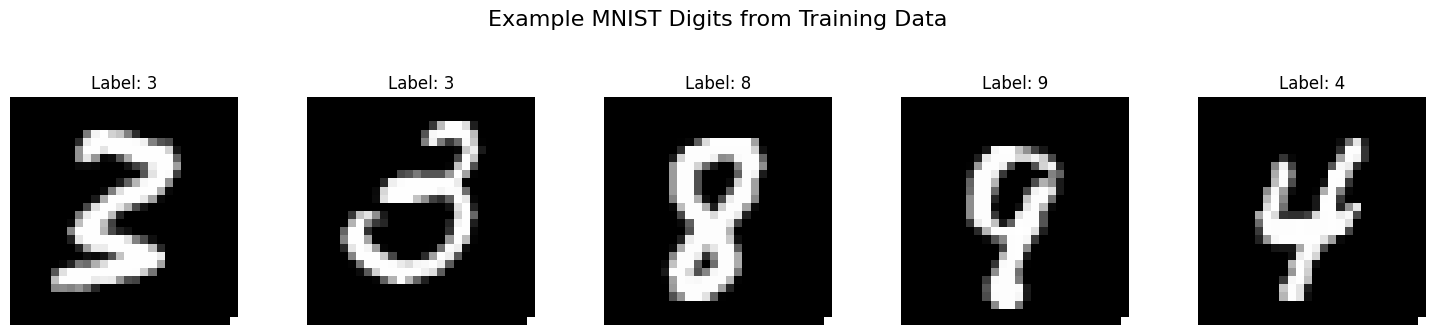

Training Random Forest classifier...
Evaluating model performance...

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        94
           1       1.00      0.97      0.99       113
           2       0.92      0.92      0.92       110
           3       0.89      0.89      0.89       117
           4       0.91      0.92      0.91        85
           5       0.92      0.92      0.92       103
           6       0.94      0.96      0.95        92
           7       0.93      0.92      0.92        97
           8       0.89      0.90      0.90       103
           9       0.89      0.88      0.89        86

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



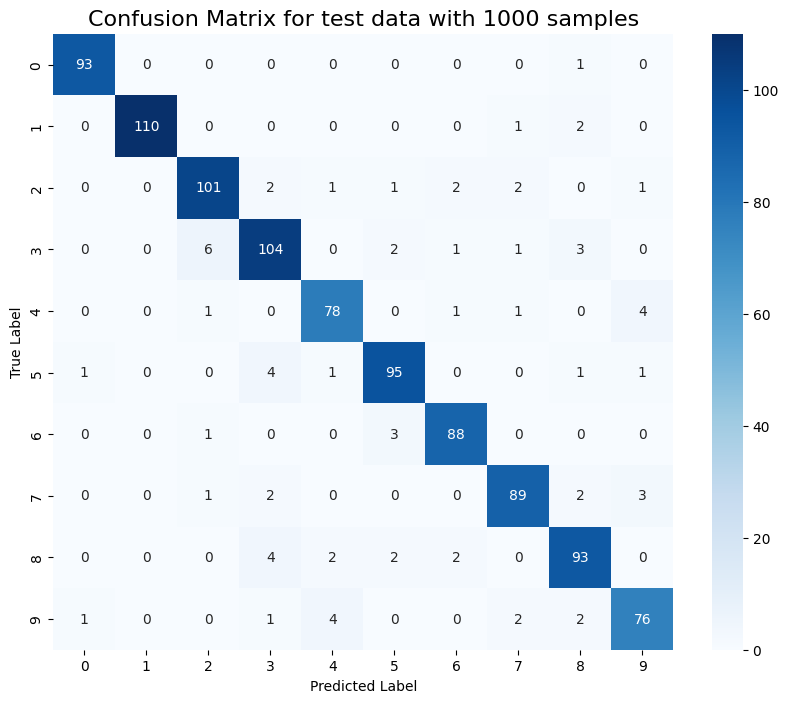

Performance Metrics for MNIST Digit Classification:

1. Overall Accuracy:
   Definition: Proportion of correct predictions among total predictions
   Value: 0.927 (92.7%)

2. Per-class Precision:
   Definition: Proportion of correct positive predictions for each digit
   Digit 0: 0.979
   Digit 1: 1.000
   Digit 2: 0.918
   Digit 3: 0.889
   Digit 4: 0.907
   Digit 5: 0.922
   Digit 6: 0.936
   Digit 7: 0.927
   Digit 8: 0.894
   Digit 9: 0.894
   Macro-average precision: 0.927

3. Per-class Recall (Sensitivity):
   Definition: Proportion of actual positives correctly identified for each digit
   Digit 0: 0.989
   Digit 1: 0.973
   Digit 2: 0.918
   Digit 3: 0.889
   Digit 4: 0.918
   Digit 5: 0.922
   Digit 6: 0.957
   Digit 7: 0.918
   Digit 8: 0.903
   Digit 9: 0.884
   Macro-average recall: 0.927

4. Per-class F1-Score:
   Definition: Harmonic mean of precision and recall for each digit
   Digit 0: 0.984
   Digit 1: 0.987
   Digit 2: 0.918
   Digit 3: 0.889
   Digit 4: 0.912
   Dig

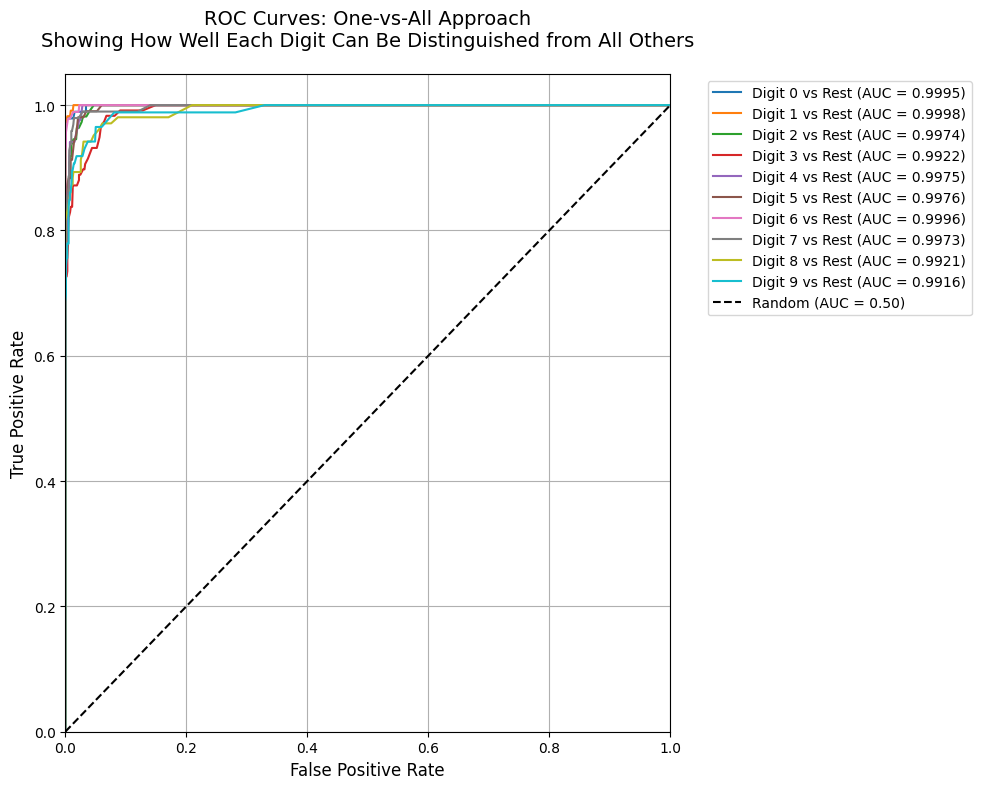


ROC AUC Interpretation:
Each curve shows how well the model can distinguish one digit from all others.
For example, 'Digit 5 vs Rest' shows how well the model can:
- Correctly identify 5s (True Positive Rate)
- Avoid mislabeling other digits as 5 (False Positive Rate)

Per-digit ROC AUC scores:
Digit 0 vs Rest: 0.9995
Digit 1 vs Rest: 0.9998
Digit 2 vs Rest: 0.9974
Digit 3 vs Rest: 0.9922
Digit 4 vs Rest: 0.9975
Digit 5 vs Rest: 0.9976
Digit 6 vs Rest: 0.9996
Digit 7 vs Rest: 0.9973
Digit 8 vs Rest: 0.9921
Digit 9 vs Rest: 0.9916

ROC AUC Scores:
Definition: Area Under the Receiver Operating Characteristic Curve
Mean ROC AUC: 0.9965


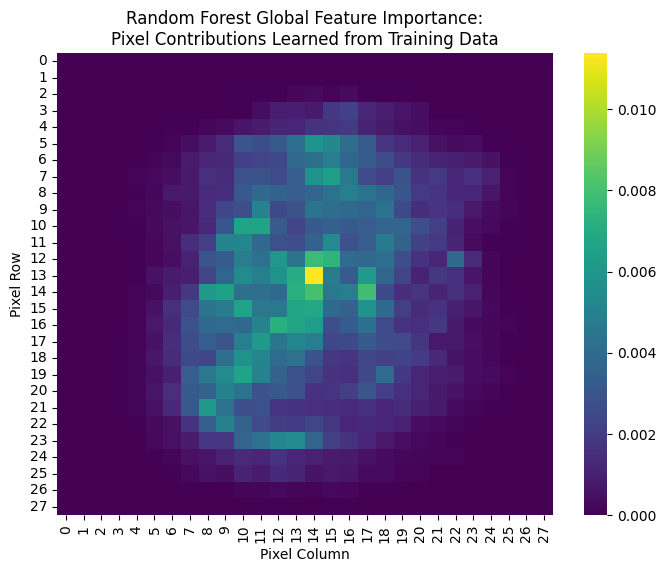

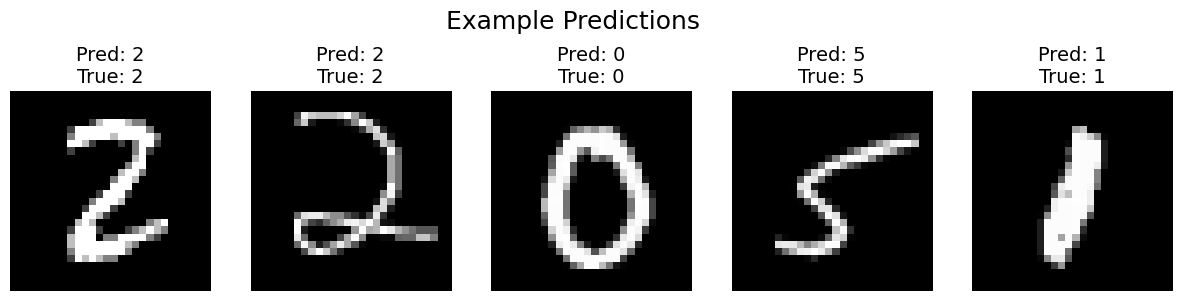

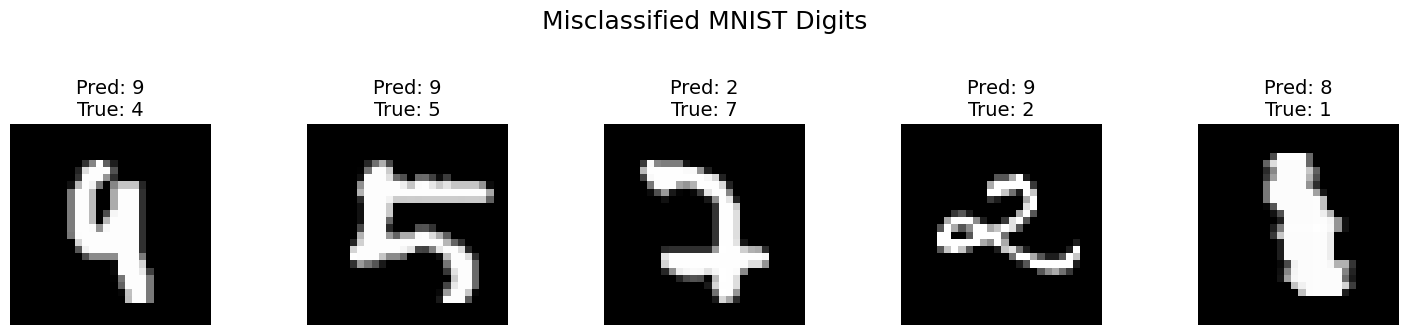


Model saved as 'mnist_images/mnist_random_forest_5000x785.joblib'


In [39]:
# Notebook 1: MNIST Classification using Random Forest
# ================================================
# This notebook demonstrates how to classify MNIST digits using a Random Forest
# classifier on the tabular representation of the data.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns


# 1. Data Loading and Preprocessing
# --------------------------------
print("Loading MNIST data from CSV...")

# Load mnist data from csv
mnist_data = pd.read_csv(f'mnist_images/mnist_data_{n_desired_samples}x{df.shape[1]}.csv')
#mnist_data = pd.read_csv('mnist_images/mnist_data_1000x785.csv')

# Print dimensions of the data
print(f"Data dimensions: {mnist_data.shape}")

# Split into training and test data
train_data, test_data = train_test_split(mnist_data, test_size=0.2, random_state=42)

# Separate features (already normalized) and labels
X_train = train_data.drop('label', axis=1) 
y_train = train_data['label']
X_test = test_data.drop('label', axis=1) 
y_test = test_data['label']

# 2. Data Visualization
# --------------------
# First, let's check what labels we actually have in train_data
print("First 5 labels in train_data:")
print(train_data['label'].head())

def plot_digit(data, index, predictions=None):
    """Plot a single MNIST digit."""
    digit = data.iloc[index, 1:].values.reshape(28, 28)
    plt.imshow(digit, cmap='gray', vmin=0, vmax=1)  # Added contrast control
    plt.axis('off')
    
    # Add debug print to verify the label being accessed
    true_label = int(data.iloc[index]['label'])  # Access 'label' column directly
    if predictions is not None:
        pred_label = int(predictions[index])
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    else:
        plt.title(f'Label: {true_label}')

# Plot a few example digits
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_digit(train_data, i)
plt.suptitle("Example MNIST Digits from Training Data", y=1.1, fontsize=16)  # Added data source
plt.tight_layout()
plt.show()


# 3. Model Training
# ----------------
print("Training Random Forest classifier...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)


# 4. Model Evaluation
# ------------------
print("Evaluating model performance...")
y_pred = rf_classifier.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# Add title and labels to the plot
plt.title(f'Confusion Matrix for test data with {len(y_test)} samples', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate and display various performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Per-class metrics
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Macro averages
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Performance Metrics for MNIST Digit Classification:\n")

print("1. Overall Accuracy:")
print(f"   Definition: Proportion of correct predictions among total predictions")
print(f"   Value: {accuracy:.3f} ({accuracy*100:.1f}%)\n")

print("2. Per-class Precision:")
print("   Definition: Proportion of correct positive predictions for each digit")
for digit in range(10):
    print(f"   Digit {digit}: {precision[digit]:.3f}")
print(f"   Macro-average precision: {macro_precision:.3f}\n")

print("3. Per-class Recall (Sensitivity):")
print("   Definition: Proportion of actual positives correctly identified for each digit")
for digit in range(10):
    print(f"   Digit {digit}: {recall[digit]:.3f}")
print(f"   Macro-average recall: {macro_recall:.3f}\n")

print("4. Per-class F1-Score:")
print("   Definition: Harmonic mean of precision and recall for each digit")
for digit in range(10):
    print(f"   Digit {digit}: {f1[digit]:.3f}")
print(f"   Macro-average F1-score: {macro_f1:.3f}\n")

# Calculate error rate
error_rate = 1 - accuracy
print("5. Error Rate:")
print("   Definition: Proportion of incorrect predictions among total predictions")
print(f"   Value: {error_rate:.3f} ({error_rate*100:.1f}%)")

#  Calculate and plot the ROC AUC curves for each digit (one-vs-all approach) 
#  since this is a multi-class problem:

# Get probability predictions
y_prob = rf_classifier.predict_proba(X_test)

# Binarize the labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=range(10))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for digit in range(10):
    # For each digit:
    # y_test_bin[:, digit] = 1 for the current digit, 0 for all others
    # y_prob[:, digit] = probability of being the current digit
    fpr[digit], tpr[digit], _ = roc_curve(y_test_bin[:, digit], y_prob[:, digit])
    roc_auc[digit] = auc(fpr[digit], tpr[digit])
    plt.plot(fpr[digit], tpr[digit],
             label=f'Digit {digit} vs Rest (AUC = {roc_auc[digit]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: One-vs-All Approach\nShowing How Well Each Digit Can Be Distinguished from All Others', 
          fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print interpretation
print("\nROC AUC Interpretation:")
print("Each curve shows how well the model can distinguish one digit from all others.")
print("For example, 'Digit 5 vs Rest' shows how well the model can:")
print("- Correctly identify 5s (True Positive Rate)")
print("- Avoid mislabeling other digits as 5 (False Positive Rate)")
print("\nPer-digit ROC AUC scores:")
for digit in range(10):
    print(f"Digit {digit} vs Rest: {roc_auc[digit]:.4f}")


# Print average AUC
mean_auc = sum(roc_auc.values()) / 10
print("\nROC AUC Scores:")
print("Definition: Area Under the Receiver Operating Characteristic Curve")
print(f"Mean ROC AUC: {mean_auc:.4f}")


# 5. Feature Importance Analysis
# ----------------------------
# Get feature importance scores
importance = rf_classifier.feature_importances_
pixel_importance = importance.reshape(28, 28)

# Plot feature importance heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pixel_importance, cmap='viridis')
plt.title('Random Forest Global Feature Importance:\nPixel Contributions Learned from Training Data')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()


# 6. Example Predictions
# --------------------
# Select a few test examples
n_examples = 5
example_indices = np.random.randint(0, len(X_test), n_examples)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(example_indices):
    plt.subplot(1, 5, i+1)
    img = X_test.iloc[idx].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    # Convert to DataFrame with proper feature names to avoid the warning
    example_data = pd.DataFrame([X_test.iloc[idx]], columns=X_train.columns)
    pred = rf_classifier.predict(example_data)[0]
    true = y_test.iloc[idx]
    plt.title(f'Pred: {pred}\nTrue: {true}', fontsize=14)  # Increased subplot title font size
plt.suptitle("Example Predictions", y=1.1, fontsize=18)  # Increased suptitle font size
plt.show()


# 7. Example Misclassifications
# ---------------------------
# Find misclassified examples
y_pred = rf_classifier.predict(X_test)
misclassified_idx = np.where(y_test != y_pred)[0]

# Plot up to 5 misclassified examples
n_examples = min(5, len(misclassified_idx))
plt.figure(figsize=(15, 3))

for i in range(n_examples):
    plt.subplot(1, 5, i+1)
    idx = misclassified_idx[i]
    img = X_test.iloc[idx].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    pred = y_pred[idx]
    true = y_test.iloc[idx]
    plt.title(f'Pred: {pred}\nTrue: {true}', fontsize=14)  # Increased subplot title font size

plt.suptitle("Misclassified MNIST Digits", y=1.1, fontsize=18)  # Increased suptitle font size
plt.tight_layout()
plt.show()

# 8. Save the Model (Optional)
# --------------------------
import joblib
joblib.dump(rf_classifier, f'mnist_images/mnist_random_forest_{n_desired_samples}x{df.shape[1]}.joblib')
print(f"\nModel saved as 'mnist_images/mnist_random_forest_{n_desired_samples}x{df.shape[1]}.joblib'")
